In [1]:
import numpy as np
import lz4
import nibabel
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.nn import pyro_method, DenseNN
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions import RelaxedBernoulliStraightThrough
import sys
sys.path.insert(0,"../data/")
import torch
from loader import *

In [2]:
def init_weights(m):
    if (type(m) == nn.Conv3d or
        type(m) == nn.ConvTranspose2d or
        type(m) == nn.Conv2d
       or type(m)== nn.Linear):
        nn.init.kaiming_normal_(m.weight,mode='fan_in',a=.01,nonlinearity="leaky_relu")
        nn.init.zeros_(m.bias)

In [3]:
def crop(x,x1,x2,y1,y2,z1,z2):
    return x[x1:x2,y1:y2,z1:z2]
def downsample(x,factorx,factory=None,factorz=None):
    if factory==None:
        factory=factorx
    if factorz==None:
        factorz=factorx
    return x[::factorx,::factory,::factorz]
def brain_slice(x,slice_num):
    return x[:,:,slice_num]
def normalize(x,norm_type=None):
    x-=np.min(x,keepdims=True)
    x/=(np.max(x,keepdims=True)+.00001)
    return x
    
def load_one_brain(path):
    img=nibabel.load(path)
    img=img.get_fdata()
    
    print(img.shape)
    img=crop(img,50,178,50,178,12,140)
    print(img.shape)
    return img


In [4]:
def view_slice(volume,slice_num):
    plt.imshow(volume[:,:,slice_num],cmap="Greys")

In [5]:
basic_brain=load_one_brain("/usr/local/faststorage/BraTS19_Data/Training/Data/BraTS19_2013_3_1/BraTS19_2013_3_1_flair.nii.gz")


(240, 240, 155)
(128, 128, 128)


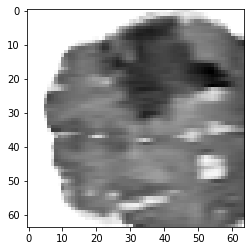

In [6]:
view_slice(downsample(basic_brain,2),32)

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim=512,k=4):
        super().__init__()
        self.conv1=nn.Conv2d(1, k, kernel_size=3, stride=1)
        self.conv2=nn.Conv2d(k, 4*k, kernel_size=4, stride=2,padding=2)
        self.pass_conv_1=nn.Conv2d(4*k, 16, kernel_size=3, stride=1,padding="same")
        self.conv3=nn.Conv2d(4*k, 4*k, kernel_size=3, stride=2,padding=1)
        self.pass_conv_2=nn.Conv2d(4*k, 16, kernel_size=3, stride=1,padding="same")
        self.conv4=nn.Conv2d(4*k, 8*k, kernel_size=3, stride=2,padding=1)
        self.conv5=nn.Conv2d(8*k, 8*k, kernel_size=3, stride=2,padding=1)
        #self.fc1=nn.Linear(6*k*8*8,64)
        self.z_mean_fc=nn.Linear(4*4*8*k,z_dim)
        self.z_std_fc=nn.Linear(4*4*8*k,z_dim)
        self.lrelu=nn.LeakyReLU()
        self.in1=nn.BatchNorm2d(k)
        self.in2=nn.BatchNorm2d(4*k)
        self.in3=nn.BatchNorm2d(4*k)
        self.in4=nn.BatchNorm2d(8*k)
        self.Sigmoid=nn.Sigmoid()
    def forward(self, xs):
        x=self.lrelu(self.in1(self.conv1(xs)))
        
        x=self.lrelu(self.in2(self.conv2(x)))
        
        p1=self.pass_conv_1(x)
        x=self.lrelu(self.in3(self.conv3(x)))
        p2=self.pass_conv_2(x)
        x=self.lrelu(self.in4(self.conv4(x)))
        x=self.lrelu(self.conv5(x))
        x=x.view(x.shape[0],-1)
        z_loc=self.z_mean_fc(x)
        z_scale=torch.exp(self.z_std_fc(x))
        return z_loc,z_scale,self.Sigmoid(p1),self.Sigmoid(p2)

In [71]:
class Decoder(nn.Module):
    def __init__(self, z_dim=256,k=4):
        super().__init__()
        
        self.deconv1=torch.nn.ConvTranspose2d(z_dim//4+1, 8*k, kernel_size=4, stride=2,padding=1)
        self.deconv2=torch.nn.ConvTranspose2d(8*k, 4*k, kernel_size=4, stride=2,padding=1)
        self.deconv3=torch.nn.ConvTranspose2d(4*k, 4*k, kernel_size=4, stride=2,padding=1)
        self.deconv4=torch.nn.ConvTranspose2d(4*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.pass_conv1=torch.nn.Conv2d(2*k+16,2*k,kernel_size=3,stride=1,padding="same")
        self.deconv5=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.pass_conv2=torch.nn.Conv2d(2*k+16,2*k,kernel_size=3,stride=1,padding="same")
        self.deconv6=torch.nn.ConvTranspose2d(2*k, 2*k, kernel_size=4, stride=2,padding=1)
        self.conv1=torch.nn.Conv2d(2*k,2,kernel_size=5,stride=1,padding="same")
        self.in1=nn.BatchNorm2d(8*k)
        self.in2=nn.BatchNorm2d(4*k)
        self.in3=nn.BatchNorm2d(4*k)
        self.in4=nn.BatchNorm2d(2*k)
        self.in5=nn.BatchNorm2d(2*k)
        self.relu = nn.ReLU()
        
        self.lrelu=nn.LeakyReLU()

        self.Sigmoid = nn.Sigmoid()
        self.z_dim=z_dim
    def forward(self, z):
        z=z.view(-1,self.z_dim//4+1,2,2)
        #print(z)
        x = self.lrelu(self.in1(self.deconv1(z)))
        x = self.lrelu(self.in2(self.deconv2(x)))
        
        x = self.lrelu(self.in3(self.deconv3(x)))
        x = self.lrelu(self.in4(self.deconv4(x)))

        #x =self.relu(self.pass_conv1(torch.cat([x,p1],1)))
        
        x = self.lrelu((self.deconv5(x)))

        #x =self.relu(self.pass_conv2(torch.cat([x,p2],1)))
        #x = self.lrelu(self.deconv6(x))
        #print(x)
        x=self.conv1(x)
        #print(x.shape)
        recon_loc=x[:,0,...]
        recon_var=torch.exp(x[:,1,...])
        
        
        return recon_loc,recon_var
        


In [72]:
class ConditionalAffineTransform(ConditionalTransformModule):
    def __init__(self, context_nn, event_dim=0, **kwargs):
        super().__init__(**kwargs)
        self.event_dim = event_dim
        self.context_nn = context_nn

    def condition(self, context):
        loc, log_scale = self.context_nn(context)
        scale = torch.exp(log_scale)
        ac = transforms.AffineTransform(loc, scale, event_dim=self.event_dim)
        return ac

In [73]:
class MLP(nn.Module):
    def __init__(self, input_size=1,z_dim=64,k=4):
        super().__init__()
        fc_1=nn.Linear(input_size,4)
        fc_z_mean=nn.Linear(4,1)
        fc_z_std=nn.Linear(4,1)
        self.Sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()
    def forward(self,z,y):
        x=self.relu(fc_1(y))
        affine_1=fc_z_mean(x)
        affine_2=fc_z_std(x)
        return affine_1,affine_2
class Estimator(nn.Module):
    def __init__(self, input_size=512,z_dim=1,k=4):
        super().__init__()
        self.fc_1=nn.Linear(input_size,16)
        self.fc_z_mean=nn.Linear(16,1)
        self.fc_z_std=nn.Linear(16,1)
        self.Sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()
    def forward(self,z):
        x=self.relu(self.fc_1(z))
        affine_1=self.fc_z_mean(x)
        affine_2=torch.exp(self.fc_z_std(x))
        return affine_1,affine_2

In [74]:
class CVAE(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()
        self.encoder = Encoder(z_dim,k=32)
        self.encoder.apply(init_weights)
        self.decoder = Decoder(z_dim,k=32)
        self.decoder.apply(init_weights)

        #self.prior_net.train()
        #self.generation_net.train()
        self.z_dim=z_dim
        #self.recognition_net = Encoder(z_dim,k=4)
        self.age_nn=MLP(input_size=1,z_dim=4)
        #self.age_flow_components = ConditionalAffineTransform(context_nn=age_nn, event_dim=0)
        #self.age_flow_transforms = [self.age_flow_components]
        self.age_estimator=Estimator(input_size=512,z_dim=1)
    #@pyro_method
    #def pgm_model(self):

        #return {'age': age_base_dist}
        
    def model(self, xs,age=None):
            # register this pytorch module and all of its sub-modules with pyro
            
            pyro.module("decoder",self.decoder)
            with pyro.plate("data",xs.shape[0]):
                
                #obs=pgm_model()
                age_mean=xs.new_ones(torch.Size((xs.shape[0], 1)))*60.8
                age_base_scale=xs.new_ones(torch.Size((xs.shape[0], 1)))*12.89
                age_dist = dist.Normal(age_mean, age_base_scale).to_event(1)
                age = pyro.sample('age', age_dist)
                z_loc = xs.new_zeros(torch.Size((xs.shape[0], self.z_dim)))
                z_scale = z_scale = xs.new_ones(torch.Size((xs.shape[0], self.z_dim)))
                z_base_dist = dist.Normal(z_loc, z_scale)
                z = pyro.sample('latent',z_base_dist.to_event(1))
                ctx=torch.cat([z,age,age,age,age],-1)  
                #ctx=torch.cat([z],-1)  
                
                #RelaxedBernoulliStraightThrough
                #z_probs_1=xs.new_ones(torch.Size((xs.shape[0], 16, 32, 32)))*.5                
                #z_dist_1 = pyro.sample("z_1",RelaxedBernoulliStraightThrough(torch.Tensor([2./3]).cuda(),probs=z_probs_1).to_event(3))
                #z_probs_2=xs.new_ones(torch.Size((xs.shape[0], 16, 16, 16)))*.5                
                #z_dist_2 = pyro.sample("z_2",RelaxedBernoulliStraightThrough(torch.Tensor([2./3]).cuda(),probs=z_probs_2).to_event(3))
                
                loc,var = self.decoder(ctx)
                #print(var)
                #print(loc.shape)
                pyro.sample('obs', dist.Normal(loc.unsqueeze(1),var.unsqueeze(1)).to_event(3), obs=xs)
                #return loc
    def guide(self, xs,age=None):
            pyro.module("encoder",self.encoder)
            with pyro.plate("data",xs.shape[0]):
                z_loc, z_scale,z_1,z_2 = self.encoder(xs)
                pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
                age_loc,age_scale=self.age_estimator(z_loc)
                pyro.sample('age', dist.Normal(age_loc,age_scale).to_event(1))
                #pyro.sample("z_1",RelaxedBernoulliStraightThrough(torch.Tensor([2./3]).cuda(),probs=z_1).to_event(3))
                #pyro.sample("z_2",RelaxedBernoulliStraightThrough(torch.Tensor([2./3]).cuda(),probs=z_2).to_event(3))

    def reconstruct(self,xs,age):
        z_loc, z_scale = self.encoder(xs)
        print(z_loc)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        ctx=torch.cat([z,age],-1)
        # decode the image (note we don't sample in image space)
        loc,var=self.decoder(ctx)
        return loc


In [75]:
device=torch.cuda.current_device()
pyro.clear_param_store()
my_VAE=CVAE()
my_VAE.to(device)
#optimizer = pyro.optim.Adam({"lr": learning_rate})
optimizer = pyro.optim.Adam({"lr": .001})
svi = SVI(my_VAE.model, my_VAE.guide, optimizer, loss=Trace_ELBO())

In [76]:
train_dataset= build_dataset(root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="train",mode=MODALS["T1"])
train_loader=VolumeLoader(dataset=train_dataset,root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="train",mode=MODALS["T1"])
train_pydl=torch.utils.data.DataLoader(train_loader,batch_size=64,num_workers=16,shuffle=False)

val_dataset= build_dataset(root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="val",mode=MODALS["T1"])
val_loader=VolumeLoader(dataset=val_dataset,root_dir='/usr/local/faststorage/BraTS19_Data/',dataset_type="val",mode=MODALS["T1"])
val_pydl=torch.utils.data.DataLoader(val_loader,batch_size=4,num_workers=24)


In [77]:
def train(pydl):
    loss=0.
    for i,data in enumerate(train_pydl):
        
        img=data["MRI"]
        img=img[:,50:178:2,50:178:2,63]
        img=img-torch.mean(img,axis=(1,2),keepdims=True)
        img=img/torch.std(img,axis=(1,2),keepdims=True)
        img=img.unsqueeze(1).type(torch.FloatTensor)
        #for i in range(100):
        loss+=svi.step(xs=img.cuda(),age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda())
        #break
    return loss
def precompute(pydl):
    loss=0.
    ages=[]
    for i,data in enumerate(train_pydl):
        ages.append(data["Age"].numpy())
    print(np.mean(np.asarray(ages)))
    print(np.std(np.asarray(ages)))
                    
def evaluate(pydl):
    loss=0.
    for i,data in enumerate(train_pydl):
        img=data["MRI"]
        img=img[:,50:178:2,50:178:2,63]
        img=img-torch.mean(img,axis=(1,2),keepdims=True)
        img=img/torch.std(img,axis=(1,2),keepdims=True)
        img=img.unsqueeze(1).type(torch.FloatTensor)
        loss = svi.evaluate_loss(xs=img.cuda(), age=data["Age"].type(torch.FloatTensor).view(-1,1).cuda())
    return loss

In [ ]:
train_loss=[]
val_loss=[]
val_loss_best=np.inf
#precompute(train_pydl)
for i in range(1000):
    print("epoch " +str(i))
    train_loss.append(train(train_pydl))
    print("Training loss is:" +str(train_loss[-1]))
    val_loss.append(evaluate(val_pydl))
    print("Validation loss is:" +str(val_loss[-1]))
    if train_loss[-1]<val_loss_best:
        val_loss_best=train_loss[-1]
        print(val_loss_best)
        torch.save(my_VAE, "./best_model")

epoch 0
Training loss is:6907573.660545349
Validation loss is:540079.15625
6907573.660545349
epoch 1
Training loss is:2859536.6318359375
Validation loss is:500199.44140625
2859536.6318359375
epoch 2
Training loss is:2474250.858139038
Validation loss is:470991.50146484375
2474250.858139038
epoch 3
Training loss is:2280268.6011047363
Validation loss is:431351.56689453125
2280268.6011047363
epoch 4
Training loss is:3385901.3820648193
Validation loss is:632866.046875
epoch 5
Training loss is:3180675.3821029663
Validation loss is:586977.279296875
epoch 6
Training loss is:2973266.267303467
Validation loss is:589658.7827148438
epoch 7
Training loss is:4197087.5082473755
Validation loss is:704095.5071411133
epoch 8
Training loss is:3627994.942214966
Validation loss is:735679.7260742188
epoch 9
Training loss is:3658476.707244873
Validation loss is:700746.0244140625
epoch 10
Training loss is:3385498.7953033447
Validation loss is:622659.4796142578
epoch 11
Training loss is:2981976.0676879883
Vali

Exception ignored in: Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
<bound method _ConnectionBase.__del__ of <multiprocessing.connection.Connection object at 0x7f77fc85cb70>>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 132, in __del__
OSError: [Errno 9] Bad file descriptor
 

Training loss is:976659.3360824585
Validation loss is:201817.173828125
976659.3360824585
epoch 65
Training loss is:960215.8331756592
Validation loss is:197574.19921875
960215.8331756592
epoch 66
Training loss is:942272.9835205078
Validation loss is:195547.3203125
942272.9835205078
epoch 67
Training loss is:928299.4883880615
Validation loss is:192002.71875
928299.4883880615
epoch 68
Training loss is:915133.4756317139
Validation loss is:189562.7109375
915133.4756317139
epoch 69
Training loss is:899922.5335845947
Validation loss is:186682.638671875
899922.5335845947
epoch 70
Training loss is:890277.104598999
Validation loss is:184819.509765625
890277.104598999
epoch 71
Training loss is:876843.9966125488
Validation loss is:182856.640625
876843.9966125488
epoch 72
Training loss is:867558.8143081665
Validation loss is:180340.796875
867558.8143081665
epoch 73
Training loss is:855428.2816085815
Validation loss is:178864.451171875
855428.2816085815
epoch 74
Training loss is:849681.7374420166
Va

In [ ]:
plt.imshow(my_VAE.reconstruct(torch.Tensor(resha_slice),age=torch.Tensor([[50]]).view(1,1)).detach().numpy().squeeze())

In [ ]:
print(len(train_dataset))

In [ ]:
for i, 